# Capstone Project

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

We are trying to solve the problem that where to set the specified place for people to get covid vaccine injected and kept from herd infection.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of potential clusters
* number of and distance from station

We will use a credential data about population movement data provided by a large communication technology company.

### Neighborhood Candidates

We can find a bunch of candidate via Google Maps geocoding API.

In [1]:
***api key*****

In [2]:
import requests

def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]
    
ikebukuro = get_coordinates(google_api_key, address)
print('Coordinate of {}: {}'.format(address, ikebukuro))

Coordinate of Ikebukuro, Tokyo, Japan: [35.7348314, 139.7077314]


Now let's create a grid of area candidates.

In [3]:
!pip install pyproj

In [4]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('ikebukuro longitude={}, latitude={}'.format(ikebukuro[1], ikebukuro[0]))
x, y = lonlat_to_xy(ikebukuro[1], ikebukuro[0])
print('ikebukuro UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('ikebukuro longitude={}, latitude={}'.format(lo, la))

Coordinate transformation check
-------------------------------
ikebukuro longitude=139.7077314, latitude=35.7348314
ikebukuro UTM X=5643738.958624326, Y=14266239.036278928


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


ikebukuro longitude=139.70773140000009, latitude=35.73483140000003


In [7]:
ikebukuro_x, ikebukuro_y = lonlat_to_xy(ikebukuro[1], ikebukuro[0]) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = ikebukuro_x - 6000
x_step = 600
y_min = ikebukuro_y - 6000 - (int(21/k)*k*600 - 12000)/2
y_step = 600 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(ikebukuro_x, ikebukuro_y, x, y)
        if (distance_from_center <= 6001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io

364 candidate neighborhood centers generated.


Let's visualize the data we have so far: city center location and candidate neighborhood centers:

In [8]:
#!pip install folium

import folium

In [9]:
map_ikebukuro = folium.Map(location=ikebukuro, zoom_start=13)
folium.Marker(ikebukuro, popup='Alexanderplatz').add_to(map_ikebukuro)
for lat, lon in zip(latitudes, longitudes):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_ikebukuro)
    #folium.Marker([lat, lon]).add_to(map_berlin)
map_ikebukuro

OK, we now have the coordinates of centers of neighborhoods/areas to be evaluated, equally spaced (distance from every point to it's neighbors is exactly the same) and within ~6km from Ikebukuro. 

Let's now use Google Maps API to get approximate addresses of those locations.

In [10]:

def get_address(api_key, latitude, longitude, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&latlng={},{}'.format(api_key, latitude, longitude)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        address = results[0]['formatted_address']
        return address
    except:
        return None

addr = get_address(google_api_key, ikebukuro[0], ikebukuro[1])
print('Reverse geocoding check')
print('-----------------------')
print('Address of [{}, {}] is: {}'.format(ikebukuro[0], ikebukuro[1], addr))

Reverse geocoding check
-----------------------
Address of [35.7348314, 139.7077314] is: 3-chōme-58-21 Ikebukuro, Toshima City, Tokyo 171-0014, Japan


In [11]:
print('Obtaining location addresses: ', end='')
addresses = []
for lat, lon in zip(latitudes, longitudes):
    address = get_address(google_api_key, lat, lon)
    if address is None:
        address = 'NO ADDRESS'
    address = address.replace(', Japan', '') # We don't need country part of address
    addresses.append(address)
    print(' .', end='')
print(' done.')

Obtaining location addresses:  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


In [12]:
addresses[150:155]

['2-chōme-21-15 Nishiochiai, Shinjuku City, Tokyo 161-0031',
 'Japan, 〒165-0024 Tokyo, Nakano City, Matsugaoka, 1-chōme−6−９ 藤ハイツ',
 '4-chōme-14-3 Arai, Nakano City, Tokyo 165-0026',
 '6-chōme-1-10 Ōji, Kita City, Tokyo 114-0002',
 '2-chōme-7-19 Ōji, Kita City, Tokyo 114-0002']

now place all this into a Pandas dataframe.

In [13]:
import pandas as pd

df_locations = pd.DataFrame({'Address': addresses,
                             'Latitude': latitudes,
                             'Longitude': longitudes,
                             'X': xs,
                             'Y': ys,
                             'Distance from center': distances_from_center})

df_locations.head(10)

,Address,Latitude,Longitude,X,Y,Distance from center
0,"4-chōme-34-1 Maenochō, Itabashi City, Tokyo 17...",35.771926,139.688620,5.641939e+06,1.426052e+07,5992.495307
1,"5-chōme-15-12 Maenochō, Itabashi City, Tokyo 1...",35.769321,139.684849,5.642539e+06,1.426052e+07,5840.376700
2,"1-chōme-11-4 Nakadai, Itabashi City, Tokyo 174...",35.766717,139.681078,5.643139e+06,1.426052e+07,5747.173218
3,"Japan, 〒174-0071 Tokyo, Itabashi City, Tokiwad...",35.764112,139.677308,5.643739e+06,1.426052e+07,5715.767665
4,"2-chōme-3-5 Kamiitabashi, Itabashi City, Tokyo...",35.761507,139.673539,5.644339e+06,1.426052e+07,5747.173218
5,"1-chōme-21-5 Nishiki, Nerima City, Tokyo 179-0082",35.758902,139.669770,5.644939e+06,1.426052e+07,5840.376700
6,"2-chōme-21-5 Hikawadai, Nerima City, Tokyo 179...",35.756298,139.666001,5.645539e+06,1.426052e+07,5992.495307
7,"1-chōme-10-5 Shimura, Itabashi City, Tokyo 174...",35.773172,139.697045,5.641039e+06,1.426104e+07,5855.766389
8,"3-chōme-38-15 Maenochō, Itabashi City, Tokyo 1...",35.770567,139.693273,5.641639e+06,1.426104e+07,5604.462508
9,"2-chōme-45-8 Maenochō, Itabashi City, Tokyo 17...",35.767962,139.689502,5.642239e+06,1.426104e+07,5408.326913


### csv file

In [14]:
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 


print('Libraries imported.')

Libraries imported.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
df1=pd.read_csv('population-movement.csv')
x1=df1['lati']
y1=df1['long']

Text(0.5, 1.0, 'Population Movement GPS data')

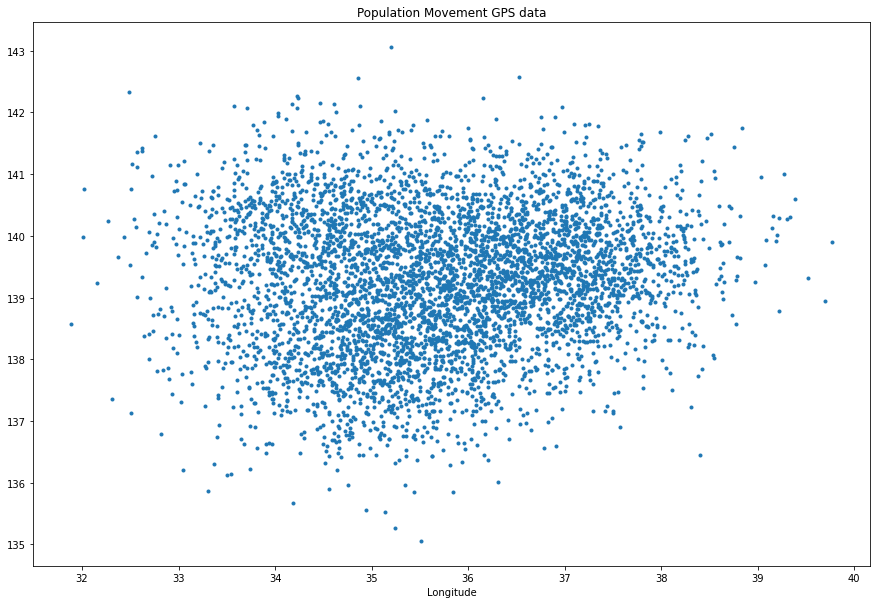

In [37]:
plt.figure(figsize=(15, 10))
plt.scatter(x1,y1, marker='.')

plt.xlabel('Latitude')
plt.xlabel('Longitude')
plt.title('Population Movement GPS data')

In [43]:
colors_map = np.array(['b', 'r'])
def assign_members(x1, x2, centers):
    compare_to_first_center = np.sqrt(np.square(np.array(x1) - centers[0][0]) + np.square(np.array(x2) - centers[0][1]))
    compare_to_second_center = np.sqrt(np.square(np.array(x1) - centers[1][0]) + np.square(np.array(x2) - centers[1][1]))
    class_of_points = compare_to_first_center > compare_to_second_center
    colors = colors_map[class_of_points + 1 - 1]
    return colors, class_of_points

print('assign_members function defined!')

assign_members function defined!


#### Define a function that updates the centroid of each cluster


In [44]:
# update means
def update_centers(x1, x2, class_of_points):
    center1 = [np.mean(np.array(x1)[~class_of_points]), np.mean(np.array(x2)[~class_of_points])]
    center2 = [np.mean(np.array(x1)[class_of_points]), np.mean(np.array(x2)[class_of_points])]
    return [center1, center2]

print('assign_members function defined!')

assign_members function defined!


#### Define a function that plots the data points along with the cluster centroids


In [45]:
def plot_points(centroids=None, colors='g', figure_title=None):
    # plot the figure
    fig = plt.figure(figsize=(12, 6))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    
    centroid_colors = ['bx', 'rx']
    if centroids:
        for (i, centroid) in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], centroid_colors[i], markeredgewidth=5, markersize=20)
    plt.scatter(x1, y1, s=10, c=colors)
    
    # define the ticks
    xticks = np.linspace(32, 40, 20, endpoint=True)
    yticks = np.linspace(138, 144, 20, endpoint=True)

    # fix the horizontal axis
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # add tick labels
    xlabels = xticks
    ax.set_xticklabels(xlabels)
    ylabels = yticks
    ax.set_yticklabels(ylabels)

    # style the ticks
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params('both', length=2, width=1, which='major', labelsize=15)
    
    # add labels to axes
    ax.set_xlabel('x1', fontsize=5)
    ax.set_ylabel('x2', fontsize=5)
    
    # add title to figure
    ax.set_title(figure_title, fontsize=5)

    plt.show()

print('plot_points function defined!')

plot_points function defined!


#### Initialize _k_-means - plot data points


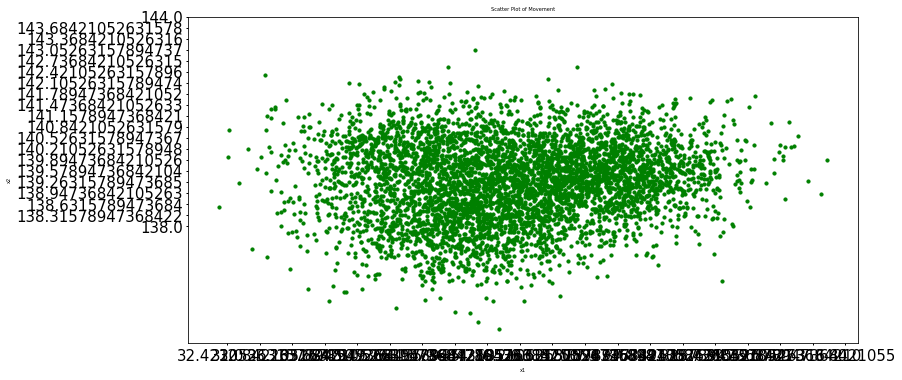

In [46]:
plot_points(figure_title='Scatter Plot of Movement')

#### Initialize _k_-means - randomly define clusters and add them to plot


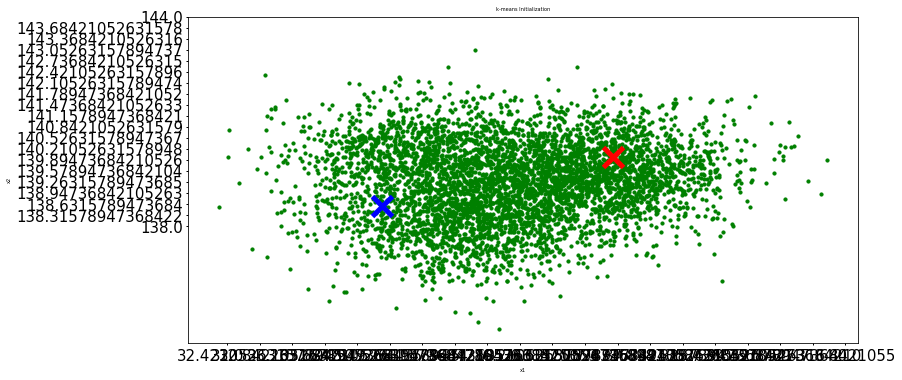

In [47]:
centers = [[34, 138.6], [37, 140]]
plot_points(centers, figure_title='k-means Initialization')

#### Run _k_-means (4-iterations only)


Iteration 1 - Press Enter to update the members of each cluster8


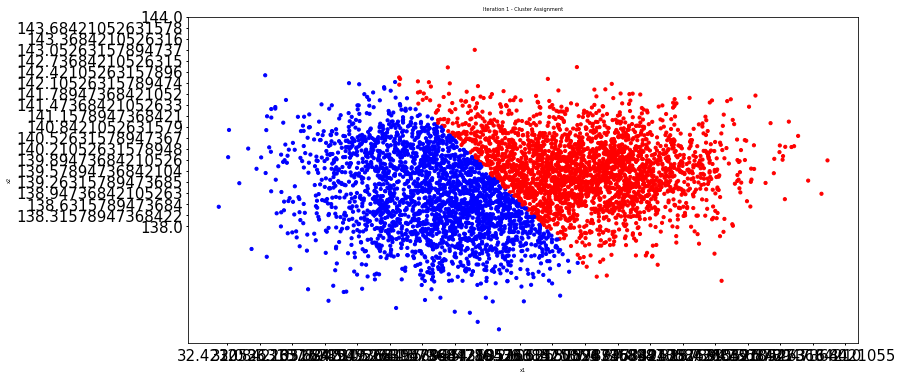

Iteration 1 - Press Enter to update the centers10


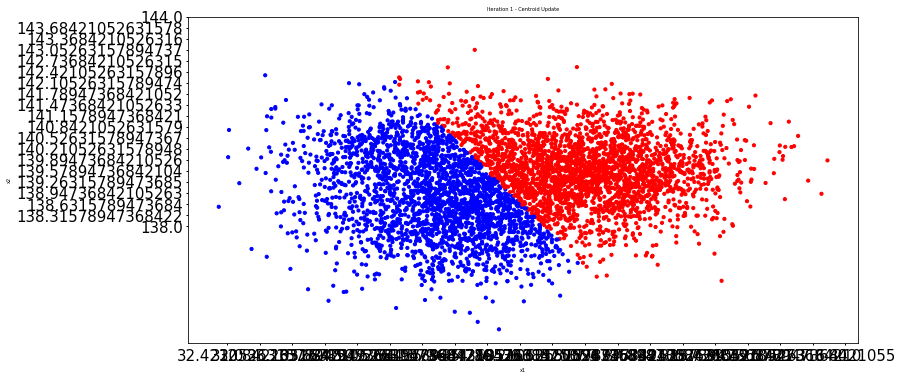

Iteration 2 - Press Enter to update the members of each cluster12


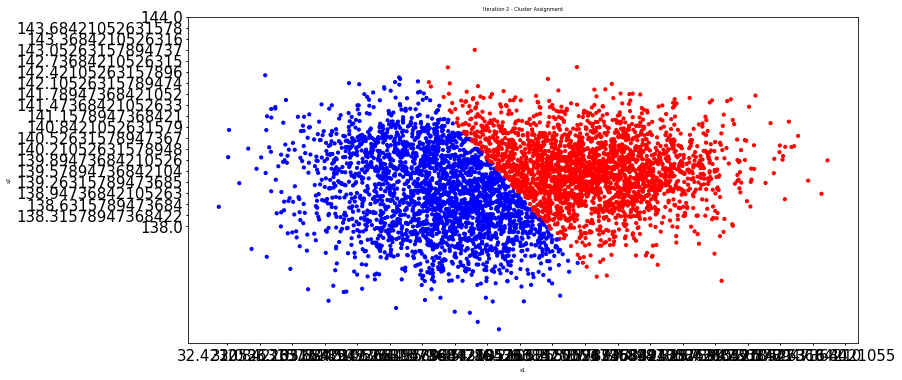

Iteration 2 - Press Enter to update the centers14


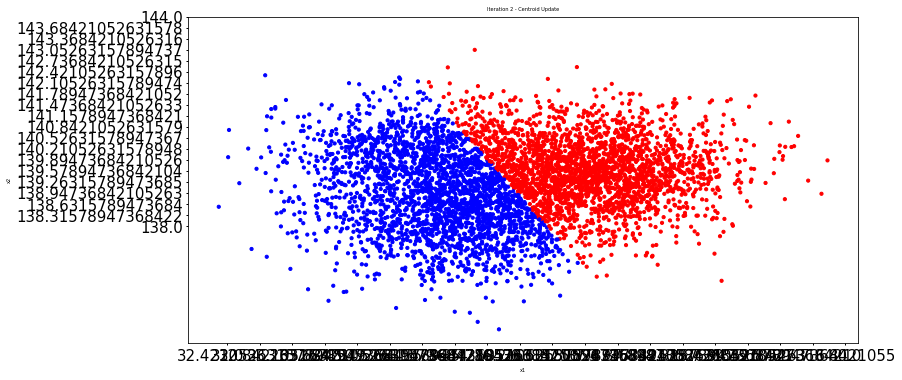

Iteration 3 - Press Enter to update the members of each cluster16


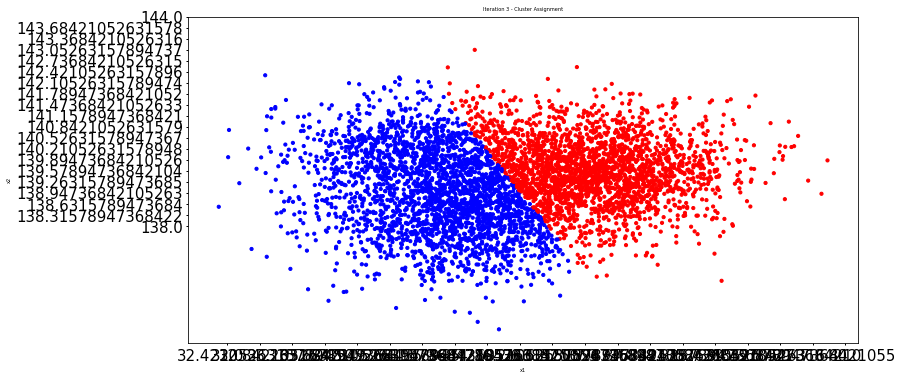

Iteration 3 - Press Enter to update the centers18


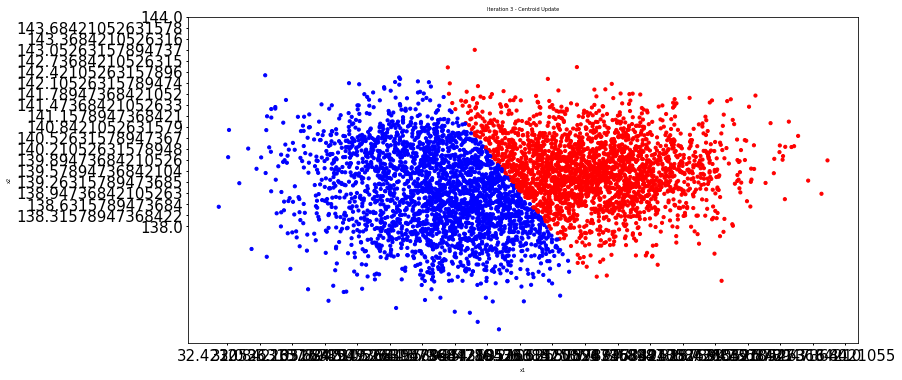

Iteration 4 - Press Enter to update the members of each cluster20


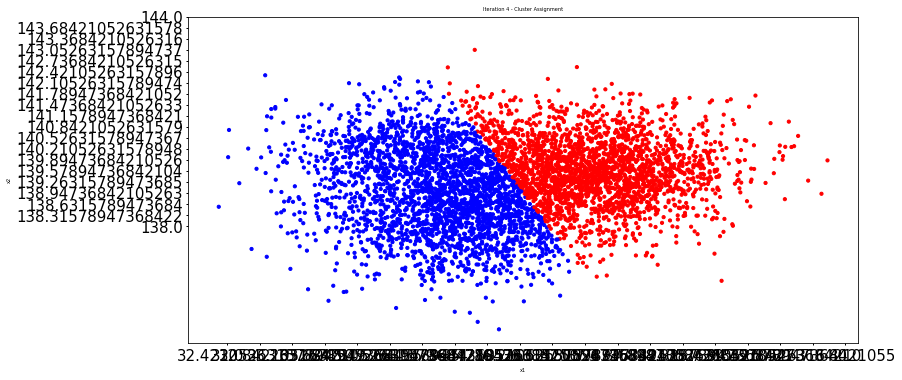

Iteration 4 - Press Enter to update the centers22


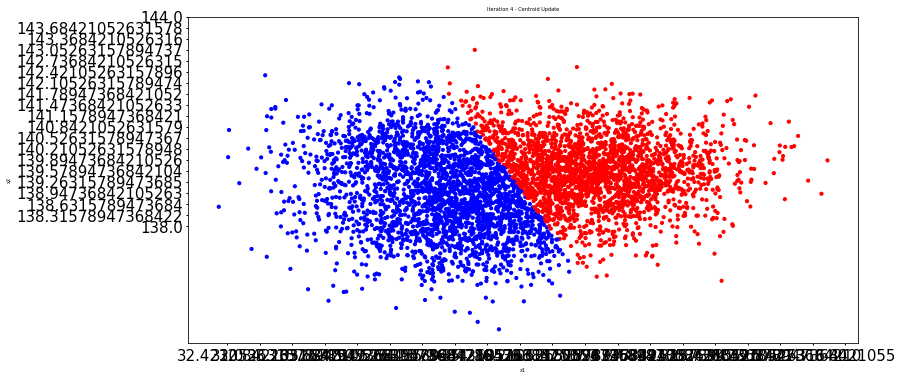

In [41]:
number_of_iterations = 4
for i in range(number_of_iterations):
    input('Iteration {} - Press Enter to update the members of each cluster'.format(i + 1))
    colors, class_of_points = assign_members(x1, y1, centers)
    title = 'Iteration {} - Cluster Assignment'.format(i + 1)
    plot_points(centers, colors, figure_title=title)
    input('Iteration {} - Press Enter to update the centers'.format(i + 1))
    centers = update_centers(x1, y1, class_of_points)
    title = 'Iteration {} - Centroid Update'.format(i + 1)
    plot_points(centers, colors, figure_title=title)

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting the centers we need for vaccine injection place.

We will use K-means to label pupulation movement. Then we will do a little EDA to visualize the place we detected.

## Analysis <a name="analysis"></a>

we need create a new df for population movement.

In [49]:
df_pop=pd.read_csv('population-movement.csv'); df_pop.head()

,lati,long
0,35.049059,139.757713
1,34.943816,139.916583
2,34.354966,140.896956
3,36.112402,139.409860
4,34.663124,136.667203


now, we will label these population by K-means and stars from 2 cluster.

In [50]:
from sklearn.preprocessing import StandardScaler

X = df_pop.values
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-0.49361799,  0.44638566],
       [-0.57474292,  0.58692843],
       [-1.02864774,  1.4542062 ],
       ...,
       [-1.28642919,  1.36477265],
       [-0.29279441, -0.88246951],
       [ 0.58281366, -0.88255062]])

Modeling

In [59]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[1 1 1 ... 1 0 0]


Assign labels

In [60]:
df_pop["Labels"] = labels
df_pop.head(5)

,lati,long,Labels
0,35.049059,139.757713,1
1,34.943816,139.916583,1
2,34.354966,140.896956,1
3,36.112402,139.409860,2
4,34.663124,136.667203,0


In [62]:
df_pop0=df_pop[df_pop['Labels']==0]
df_pop1=df_pop[df_pop['Labels']==1]
df_pop2=df_pop[df_pop['Labels']==2]

Text(0.5, 1.0, 'Population Movement GPS data')

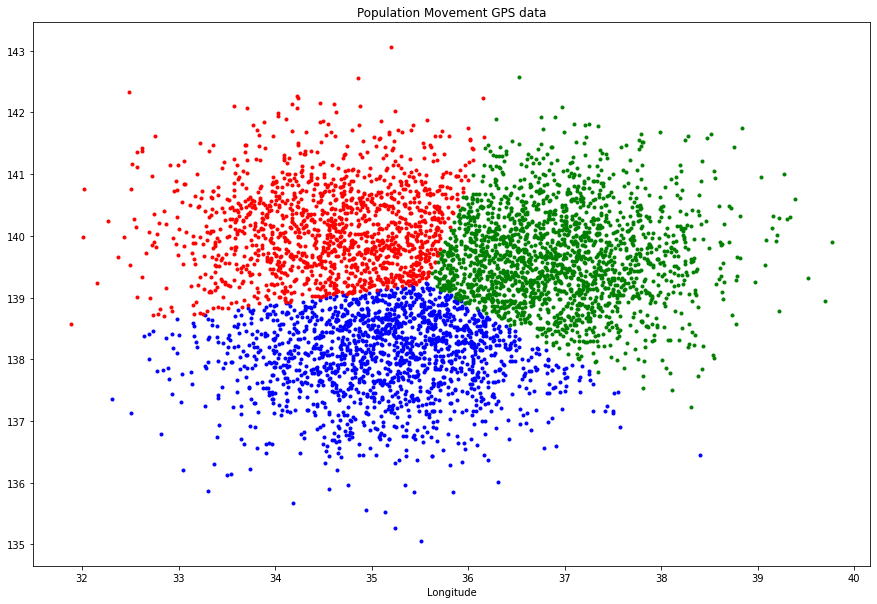

In [63]:
plt.figure(figsize=(15, 10))
plt.scatter(df_pop0['lati'], df_pop0['long'], marker='.', color='blue')
plt.scatter(df_pop1['lati'], df_pop1['long'], marker='.', color='red')
plt.scatter(df_pop2['lati'], df_pop2['long'], marker='.', color='green')

plt.xlabel('Latitude')
plt.xlabel('Longitude')
plt.title('Population Movement GPS data')

In [65]:
df_pop.groupby('Labels').mean()

,lati,long
Labels,,
0,35.158425,138.033514
1,34.559484,140.128584
2,36.940530,139.653370


In [66]:
df_locations.sort_values(['Latitude','Longitude'],ascending=True,inplace=True)

In [71]:
place0=df_locations[(df_locations['Latitude'] >=35.158425) & (df_locations['Longitude'] >=138.033514)].head(1); place0

,Address,Latitude,Longitude,X,Y,Distance from center
346,"Japan, 〒160-0022 Tokyo, Shinjuku City, Shinjuk...",35.69526,139.709964,5.647339e+06,1.427092e+07,5901.694672


In [80]:
place0['Address']

346    Japan, 〒160-0022 Tokyo, Shinjuku City, Shinjuk...
Name: Address, dtype: object

## Results and Discussion <a name="results"></a>

We can see for *label 0* cluster, we can take use of the place above for a candidate.

By using k-means, we detect 3 areas (cluster) in the population movement trace. And for center of each areas we could set the place for vaccine injection. However, we should discussion later on cost-effective analysis, for we should take perspective of cost into count.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify 3 areas and 3 center of Ikebukuro, which is hot city in Tokyo. A new data scienced oriented approach is a new try for public policy.